In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data_loader import *
from src.helpers import *
from src.htmlParser import *
import seaborn as sn
import matplotlib.pyplot as plt

parser = htmlParser()
parser.load_pickle()

NameError: name 'htmlParser' is not defined

# Section 1: blablal

## A- Data Cleaning
This part loads, cleans the data, and defines useful datasets for further analysis. 

- `read_articles()` loads a list of valid article names, that is without special characters and discardig any invalid articles, like non-wikispedia articles or with missing categories
- `parser.get_df_html_stats()` gathers wikispedia page statistics like number of links, link density, and structural information
- `read_categories()` sorts for each category of a same article its different levels of sub categories 
- `read_links()` gathers all the links outward of a page 
- `read_shortest_path_matrix()` reads the matrix of shortest paths possible between two articles 
- `read_unfinished_paths()` and `read_finished_paths()` load the original unfinished and finished paths and clean them
- `read_similartiy_matrix()` reads the matrix of semantic similarity between article names 
- `read_categories_matrix()` reads the matrix that describes the similarity between article's category levels and sub-levels

In [3]:
df_article_names = read_articles() 
df_html_stats = parser.get_df_html_stats()
df_categories = read_categories()
df_links = read_links()
df_shortest_path = read_shortest_path_matrix()
df_unfinished = read_unfinished_paths()
df_finished = read_finished_paths() 
df_sm = read_similartiy_matrix() 
df_scat = read_categories_matrix()

Unfinished Paths 
Number of rows before filtering: 24875
Invalid target articles found: {'Test', 'Rat', 'Netbook', 'Western Australia', 'Rss', 'Christmas', 'Charlottes web', 'Pikachu', ' Zebra', 'English', 'Macedonia', 'Black ops 2', 'Great', 'Kashmir', 'Georgia', 'The', 'Usa', 'Mustard', 'Podcast', 'Sportacus', 'Adolph Hitler', 'Bogota', 'The Rock', 'Fats', 'Long peper'}
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows dropped of type 'timeout' with a duration less than 30 minutes: 7
Type 'timeout' occurs only after 30 minutes of inactivity, thus this path are technically impossible.
Number of rows after filtering: 24714 

Finished Paths 
Number of rows before filtering: 51318
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51210 



## B- Exploratory Data Analysis

This part aims to explore article features and player behaviour

### Player Features Analysis???

New metrics are added to characterize the game paths. Specifically:

- **Path Length** which accounts for the total number of articles in a path

- **Back Clicks** which indicates how many times the user revisited previous articles

- **Cosine Similarity** which measures the semantic similarity between articles in the paths

- **Shortest Path** which gives the length of the shortest path possible between the source and target articles

- **Categories Similarity** which  measure the category similarity between the categories of the source and target articles

In [4]:
# let's add some useful metrics to each paths dataframe: shortest path, semantic similarity
df_unfinished['cosine_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_unfinished['shortest_path'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_unfinished['path_length'] = df_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_unfinished['back_clicks'] = df_unfinished['path'].apply(lambda x: x.count('<'))
df_unfinished["categories_similarity"] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

df_finished['cosine_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_finished['shortest_path'] = df_finished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_finished['path_length'] = df_finished['path'].apply(lambda x: x.count(';') + 1)
df_finished['back_clicks'] = df_finished['path'].apply(lambda x: x.count('<'))
df_finished["categories_similarity"] = df_finished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

#### Analysis of the similarity between source and target artiche

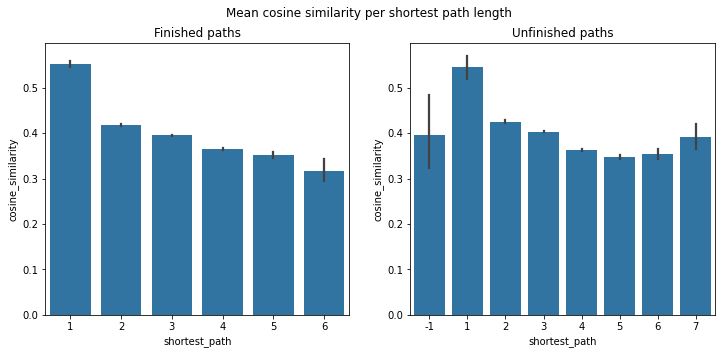

In [78]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)

df_finished_clean = df_finished[df_finished['shortest_path'] != 0].copy()

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='cosine_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='cosine_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean cosine similarity per shortest path length')
plt.show()

In [79]:
from scipy.stats import pearsonr, spearmanr

def calculate_correlations_with_shortestPath(df, column_name):
    # Ensure 'shortest_path' is numeric
    df['shortest_path'] = df['shortest_path'].astype(float)

    pearson_corr, pearson_p = pearsonr(df['shortest_path'], df[column_name])
    spearman_corr, spearman_p = spearmanr(df['shortest_path'], df[column_name])

    # Print results
    print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
    print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")

print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"cosine_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"cosine_similarity")

Finished paths:
Pearson correlation: -0.2837, p-value: 0.0000e+00
Spearman correlation: -0.2359, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.2732, p-value: 0.0000e+00
Spearman correlation: -0.2751, p-value: 0.0000e+00


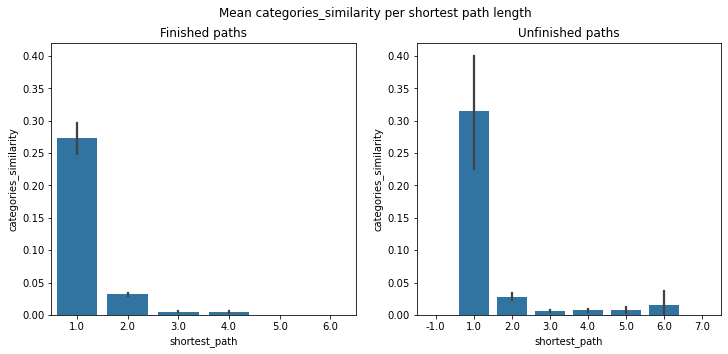

In [80]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)
# impossible paths in unfinishes paths are possible however. check if it is sound though because of the previous problem.

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='categories_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='categories_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean categories_similarity per shortest path length')
plt.show()

In [81]:
print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"categories_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"categories_similarity")

Finished paths:
Pearson correlation: -0.1968, p-value: 0.0000e+00
Spearman correlation: -0.1938, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.0763, p-value: 3.3577e-33
Spearman correlation: -0.0816, p-value: 8.2011e-38


- Pearson Correlation
Measures the linear relationship between two continuous variables.

- Spearman Correlation
Assesses the monotonic relationship using ranked data, making it less sensitive to outliers and non-linear relationships.

The p-values are effectively zero, which is highly significant statistically. This suggests that the observed correlations are unlikely to be due to random chance.

-> Thus as the distance path increase, the cosine_similarity decrease
In other words...

### Difficulty measure
Here we look for patterns in user behaviour and try to understand how we could measure whether a game was difficult or not

The mean duration of finished paths is 158 seconds
The mean duration of unfinished paths is 835 seconds


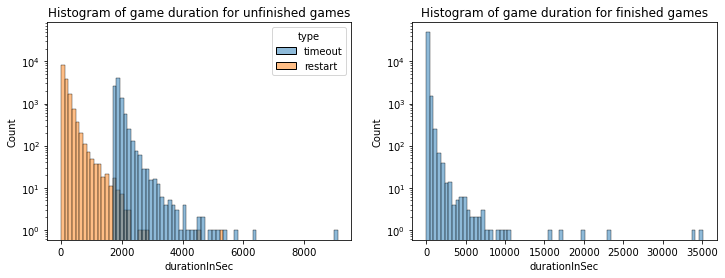

In [82]:
print(f"The mean duration of finished paths is {df_finished['durationInSec'].mean():.0f} seconds")
print(f"The mean duration of unfinished paths is {df_unfinished['durationInSec'].mean():.0f} seconds")

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=75)
plt.yscale('log')
plt.title('Histogram of game duration for unfinished games')

plt.subplot(122, sharey = ax1)
sn.histplot(df_finished, x='durationInSec', bins=75, alpha=0.5)
plt.yscale('log')
plt.title('Histogram of game duration for finished games')
plt.show()

In [83]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.863962  296.518511   3.482914   7.640866   3.706646  0.043538
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.053993  430.555836   2.853805   6.815218   4.031546  0.026722

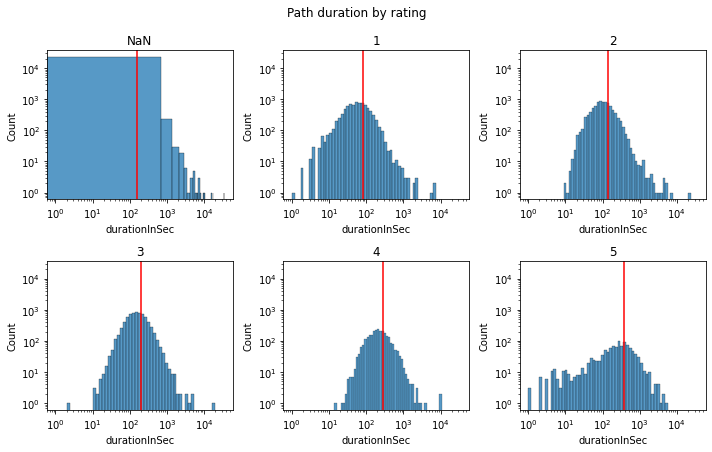

In [84]:
# Those are some nice log-normal distributions -> are they though? the distribution is normal in loglog, not log.
# except for NaN, there is a steady increase of the path duration mean when rating goes up

plt.figure(figsize=(10, 6))

means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished['rating'].isnull()], x='durationInSec', bins=50) # change x to x = 'path_length' for path length
means.append(df_finished[df_finished['rating'].isnull()]['durationInSec'].mean())
stds.append(df_finished[df_finished['rating'].isnull()]['durationInSec'].std())
plt.axvline(means[0], color='red')
plt.yscale('log')
plt.xscale('log')
plt.title('NaN')

for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    means.append(df_finished[df_finished['rating']==i]['durationInSec'].mean())
    stds.append(df_finished[df_finished['rating']==i]['durationInSec'].std())
    sn.histplot(df_finished[df_finished['rating']==i], x='durationInSec', bins=50)
    plt.axvline(means[i], color='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(i)

plt.tight_layout()
plt.suptitle('Path duration by rating', y=1.04)
plt.show()

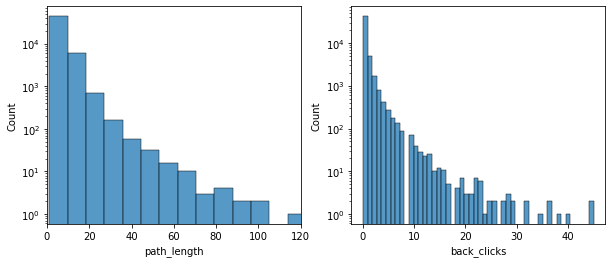

In [85]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.histplot(df_finished, x='path_length', bins=50)
plt.yscale('log')
plt.xlim(0, 120)

plt.subplot(122)
sn.histplot(df_finished, x='back_clicks', bins=50)
plt.yscale('log')

### Categories distribution in start and end paths 
The aim here is to look whether categories of the source and target articles are correlated with finishing or not a game. 

In [86]:
paths_finished = find_categories_start_end(df_finished, df_categories)
paths_unfinished = find_categories_start_end(df_unfinished, df_categories)

paths_finished["finished"] = 1
paths_unfinished["finished"] = 0

paths = pd.concat([paths_finished, paths_unfinished], join='inner')
paths_melted = paths.melt(
    id_vars=["finished"],
    value_vars=["start_category", "end_category"],
    var_name="category_type",
    value_name="category"
)

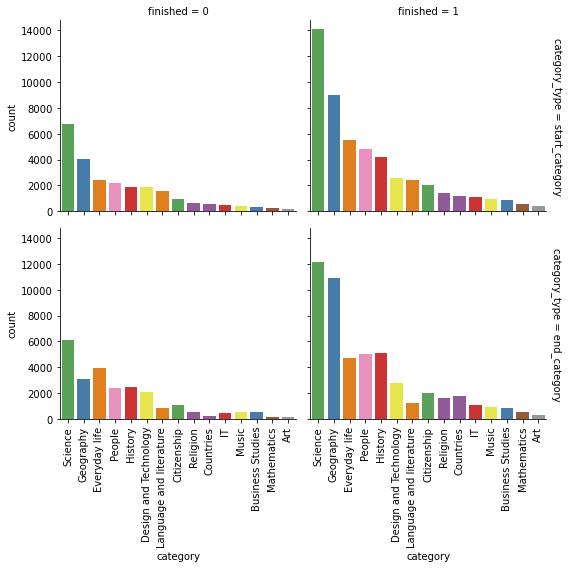

In [87]:
# Create a color palette based on unique categories
unique_categories = paths_melted['category'].unique()
palette = sn.color_palette("Set1", n_colors=len(unique_categories))
color_mapping = dict(zip(unique_categories, palette))

g = sn.FacetGrid(
    data=paths_melted,
    col="finished",
    row="category_type",
    sharey=True,
    sharex=True,
    margin_titles=True,
    height=4,
)

g.map_dataframe(
    sn.countplot,
    x="category",
    hue="category",
    palette=color_mapping,
    order=paths_melted['category'].value_counts().index  # Order by frequency
)

# Rotate x-axis labels for readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

### Corelation between difficulty and combination of source-target categories
In this part we aim to get a glance at the extend to which the choice of the source article and the end article affects the difficulty of the game.
This could highlight potential combinations of categories that are harder to connect.

Different difficulty metrics are used like path duration, path length in terms of number of clicks and user ratings. 

The number of backclicks and its link with current difficulty mettrics and categories is also studied to explore whether it indicates difficulty as well.
#### Correlation between the duration of game and the combination of source-target category
Here the difficulty measure is the game duration. 

🚨put different colors for finished ans unfinished, so the colorbar isnt the same for diffrent scales🚨

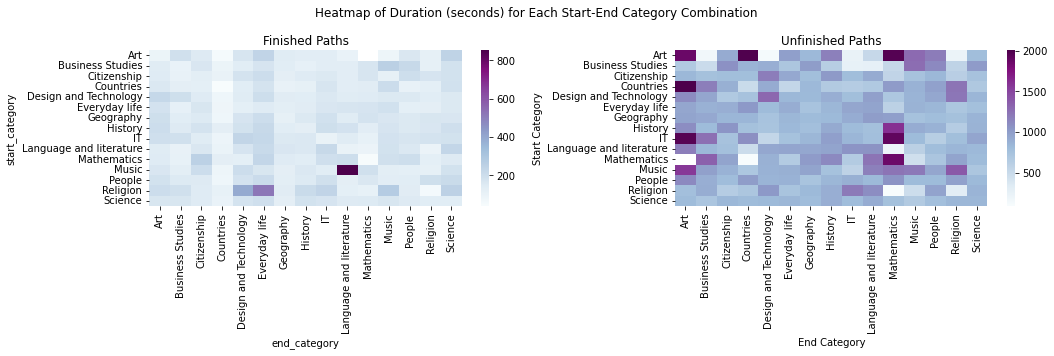

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='durationInSec', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='durationInSec',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of Duration (seconds) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

#### Correlation between the length of path and the combination of source-target category
Here the difficulty metric used is the number of clicks in the game. 

🚨put different colors for finished ans unfinished, so the colorbar isnt the same for diffrent scales🚨

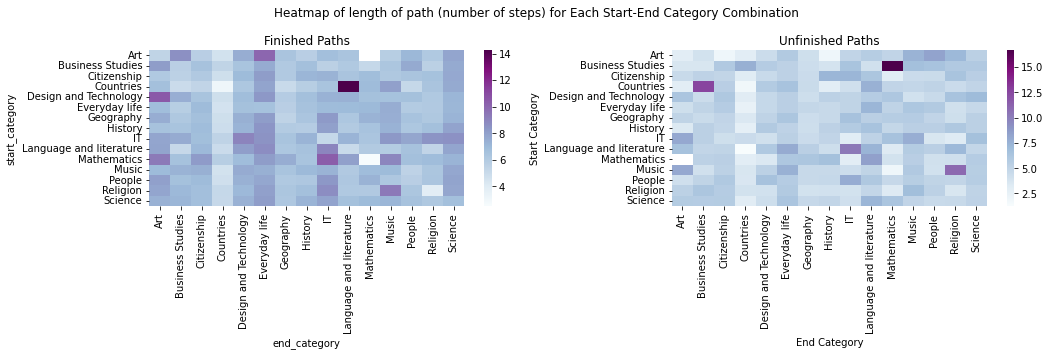

In [89]:
paths_finished["steps_count"] = paths_finished["path"].apply(lambda x: len(x.split(";")))
paths_unfinished["steps_count"] = paths_unfinished["path"].apply(lambda x: len(x.split(";")))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='steps_count', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='steps_count',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of length of path (number of steps) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

#### Correlation between the player rating and the combination of source-target category
Here we use the difficulty rating by the players as difficulty metric.

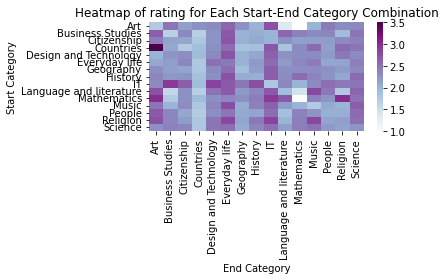

In [90]:
path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu')
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Correlation between the rating, the backclip number and the topics
Here we explore to which extend the backclicks might be correlated with difficulty and topics. 

In [91]:
df_categories_filtered = filter_most_specific_category(df_categories)
paths_finished = extract_category_path(df_finished, df_categories_filtered)
paths_finished = backtrack(paths_finished)

<ipython-input-92-acb2ccd0c44e>:5: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.



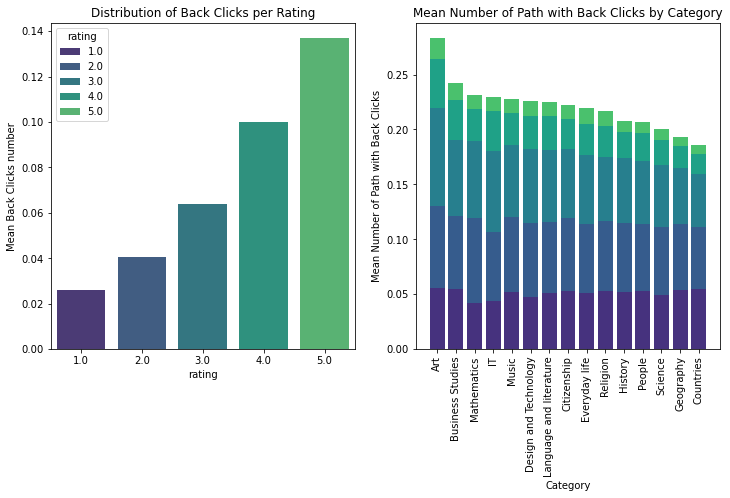

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

back_per_rating = paths_finished.groupby("rating").agg({"back_nb": "mean", "size": "mean"}).reset_index()
back_per_rating['Mean Back Clicks number'] = back_per_rating["back_nb"]/back_per_rating["size"]
sn.barplot(x="rating", y='Mean Back Clicks number', hue="rating", data=back_per_rating, palette=sn.color_palette('viridis'), ax=ax[0])

df_exploded = paths_finished.explode('category')
category_back_mean = df_exploded.groupby(['category', 'rating']).size().reset_index(name='size')
back_mean = df_exploded.groupby('category')["have_back"].mean().reset_index().sort_values(by='have_back', ascending=False)
category_back_mean = category_back_mean.merge(back_mean, on='category').sort_values(by='have_back', ascending=False)
category_back_mean['rating_proportion'] = category_back_mean.groupby('category')['size'].transform(lambda x: x / x.sum())

order = category_back_mean["category"].unique()
base_heights = category_back_mean[['category', 'have_back']].drop_duplicates().set_index('category')['have_back']
df_pivot = category_back_mean.pivot(index='category', columns='rating', values='rating_proportion').fillna(0)
df_pivot = df_pivot.reindex(order)

colors = sn.color_palette('viridis')

bottom = pd.Series([0] * len(df_pivot), index=df_pivot.index)
for i, rating in enumerate(df_pivot.columns):
    ax[1].bar(df_pivot.index, 
           height=df_pivot[rating] * base_heights,  
           bottom=bottom * base_heights,           
           label=f'Rating {rating}', 
           color=colors[i])
    bottom += df_pivot[rating]

ax[1].set_title('Mean Number of Path with Back Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Mean Number of Path with Back Clicks')
plt.xticks(rotation=90)
ax[0].set_title("Distribution of Back Clicks per Rating")
plt.show()

Show that irrespective of the start and end categories, many players path through countries and geography


## Sort games into voyage or not-voyage 

In [93]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(df_sm, cmap='BuPu')
cbar = fig.colorbar(cax)
plt.title('Cosine similarity of article names')

In [94]:
voyage_count = (df_finished_voyage['voyage'] == 1).sum() + (df_unfinished_voyage['voyage'] == 1).sum()
non_voyage_count = (df_finished_voyage['voyage'] == 0).sum() + (df_unfinished_voyage['voyage'] == 0).sum()
print('out of', len(df_finished_voyage)+len(df_unfinished_voyage), 'games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')
upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1) # Flatten the upper triangle of the matrix without the diagonal for sorting

# Get the sorted indices for most similar pairs (descending order)
sorted_similar_indices = np.argsort(-similarity_matrix[upper_triangle_indices])
top_similar_pairs = list(zip(upper_triangle_indices[0][sorted_similar_indices], 
                             upper_triangle_indices[1][sorted_similar_indices]))

print("Top 5 most similar pairs:")
for i, (idx1, idx2) in enumerate(top_similar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {similarity_matrix[idx1, idx2]:.4f}")

sorted_dissimilar_indices = np.argsort(similarity_matrix[upper_triangle_indices])
top_dissimilar_pairs = list(zip(upper_triangle_indices[0][sorted_dissimilar_indices], 
                                upper_triangle_indices[1][sorted_dissimilar_indices]))

# Print the top 5 most dissimilar pairs
print("\nTop 5 most dissimilar pairs:")
for i, (idx1, idx2) in enumerate(top_dissimilar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {similarity_matrix[idx1, idx2]:.4f}")

out of 75924 games : 
  -  37956  are voyages
  -  37968  are not


### Cluster Analysis (Hierarchical Clustering)
Find clusters of words that are more similar to each other than to words in other clusters. At the bottom of the tree, most similar pairs are formed, then pairs of pairs are compared and so on. Check out <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html> this link </a> for more detail and <a href=https://stackoverflow.com/questions/66969893/scipy-and-the-hierarchical-clustering-input> this </a> or <a href=https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial> this link </a> to get a somewhat intuitive idea how how 2D clustering works. The clustering allows to reorder the similarity matrix in a way that regroups articles with high similarity. More analysis needs to be done to understand what the clusters essentially are and represent.

In [95]:
import pandas as pd
import plotly.graph_objects as go

# Mapping for start, voyage, and end nodes
df_finished_voyage['start_category_label'] = df_finished_voyage['start_category'].apply(lambda x: 'First in Countries/Geography' if x in ['Countries', 'Geography'] else 'First not in Countries/Geography')
df_finished_voyage['end_category_label'] = df_finished_voyage['end_category'].apply(lambda x: 'Target in Countries/Geography' if x in ['Countries', 'Geography'] else 'Target not in Countries/Geography')
df_finished_voyage['voyage_label'] = df_finished_voyage['voyage'].apply(lambda x: 'Voyage' if x else 'Non-Voyage')

# Count occurrences for each flow from start -> voyage -> end
flows = df_finished_voyage.groupby(['start_category_label', 'voyage_label', 'end_category_label']).size().reset_index(name='count')

# Define nodes for the Sankey diagram
labels = ['First in Countries/Geography', 'First not in Countries/Geography',
          'Voyage', 'Non-Voyage',
          'Target in Countries/Geography', 'Target not in Countries/Geography']

# Create mappings for source and target node indices
label_map = {label: i for i, label in enumerate(labels)}

# Map flows to Sankey source, target, and value arrays
sources = []
targets = []
values = []

for _, row in flows.iterrows():
    # Add start -> voyage
    sources.append(label_map[row['start_category_label']])
    targets.append(label_map[row['voyage_label']])
    values.append(row['count'])

    # Add voyage -> end
    sources.append(label_map[row['voyage_label']])
    targets.append(label_map[row['end_category_label']])
    values.append(row['count'])


node_colors = [
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)",   
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)",   
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)"
    ]

link_colors = [
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)",   
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)",   
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)"
    ]

# Create the Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="white", width=0.1), label=labels, color=node_colors),
    link=dict(source=sources, target=targets, value=values)
)])

fig.update_layout(
    title_text="Path classification as Voyage or not",
    font_size=10,
    title_font_size=14,
    title_x=0.5,
    plot_bgcolor="white"
)

fig.show()
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# Perform hierarchical clustering
linkage_matrix = linkage(similarity_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Article Index (sorted by similarity)')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,    
    labelbottom=False)
plt.ylabel('Distance')
plt.show()

NameError: name 'similarity_matrix' is not defined

In [ ]:
ordered_indices = leaves_list(linkage_matrix)
reordered_matrix = similarity_matrix[ordered_indices, :][:, ordered_indices]

plt.figure(figsize=(12, 8))
plt.imshow(reordered_matrix, cmap='BuPu')
plt.title('Reordered Similarity Matrix')
plt.colorbar()
plt.show()

In [ ]:
print('The reordered article indices make intuitive sense, similar words are regrouped')
print(df_article_names[ordered_indices].head(10))
print(df_article_names[ordered_indices].tail(10))

## Evolution of similarity on paths

In [ ]:
df_unfinished = read_unfinished_paths()
df_finished = read_finished_paths()

all_paths = []
df_finished['path'].apply(lambda x: all_paths.append(x.split(';')))
for path in all_paths:
    for step in range(len(path)):
        if path[step] == '<':
            path[step] = path[step-2]

step_similarity = []

for path in all_paths:
    path_similarity = []
    for step in range(len(path)-1):
        current, next = sm.get_indices(df_article_names, [path[step], path[step+1]])
        path_similarity.append(similarity_matrix[current, next])

    step_similarity.append(path_similarity)

In [ ]:
paths_similarity = []
for N in range(1, 17):
    paths_len_N = []
    for path in step_similarity:
        if len(path)==N:
            paths_len_N.append(path)

    paths_similarity.append(np.array(paths_len_N))
means = [np.mean(paths_len_N, axis=0) for paths_len_N in paths_similarity]


In [ ]:
plt.figure(figsize=(16, 16))
for i in range(len(paths_similarity)):
    plt.subplot(4, 4, 1+i)
    plt.plot(paths_similarity[i].T, 'b.', alpha=0.5)
    plt.plot(means[i], 'r', lw=2)
    plt.title(f'Path length {i}')
plt.show()

### html Parsing

In [ ]:
parser = htmlParser()
print(f'There are {len(parser.article_URLs)} valid articles')

df_html_articles = parser.article_names # The html articles in the data
df_article_names = read_articles() # The articles used in the paths-and-graph data
intersect = pd.merge(df_html_articles, df_article_names, how='inner', on="article")
print(f'There are {len(df_article_names)} articles in the paths-and-graph data and {len(intersect)} of those are in the html articles.')
difference = df_html_articles[~df_html_articles.isin(df_article_names)]
print(f'This means there are {len(difference)} articles more in the html data, such as "{difference.iloc[0]}", "{difference.iloc[5]}" or "{difference.iloc[10]}".')

In [ ]:
parsed = parser.parse_html_article(parser.article_URLs[266])
if parsed: parser.get_overview(parsed)

In [ ]:
df_html_stats = parser2.get_df_html_stats()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

sort_column = widgets.Dropdown(
    options=df_html_stats.columns,
    value='total_words',
    description='Sort by:'
)

n_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Number (n):'
)

# Display function to update table based on widget values
def display_sorted(n, sort_by):
    sorted_df = df_html_stats.sort_values(by=sort_by, ascending=False)
    top_n = sorted_df.head(n)
    bottom_n = sorted_df.tail(n)
    
    print(f"\nTop {n} Articles by {sort_by}:")
    display(top_n)
    print(f"\nBottom {n} Articles by {sort_by}:")
    display(bottom_n)

# Link widgets to display function
widgets.interactive(display_sorted, n=n_slider, sort_by=sort_column)


# David Notebooks

In [5]:
from src.data_loader import *
import plotly.graph_objects as go
from src.helpers import *

## Categories Distributions

In [6]:
df_finished = read_finished_paths()
df_unfinished = read_unfinished_paths()

Finished Paths 
Number of rows before filtering: 51318
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51210 

Unfinished Paths 
Number of rows before filtering: 24875
Invalid target articles found: {'The Rock', 'Adolph Hitler', 'Fats', 'Sportacus', 'Rat', 'English', 'Christmas', 'Bogota', ' Zebra', 'Test', 'Charlottes web', 'Black ops 2', 'The', 'Mustard', 'Macedonia', 'Long peper', 'Podcast', 'Georgia', 'Kashmir', 'Great', 'Netbook', 'Western Australia', 'Usa', 'Rss', 'Pikachu'}
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows dropped of type 'timeout' with a duration less than 30 minutes: 7
Type 'timeout' occurs only after 30 minutes of inactivity, thus this path are technically impossible.
Number of rows after filtering: 24714 



In [7]:
df_categories = read_categories()
labels, parents, values, ids = create_treemap_data(df_categories)

In [8]:
# Plotting the treemap
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    #textinfo="label+value",  # Show both label and value
    textfont=dict(size=18),  # Increase font size; will automatically fit smaller labels

))
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), title="Category Distribution in Articles (Some articles have multiple categories, thus the sum of values is greater than the number of articles)")
fig.show()

- Assing to articles with multiples categories the most specific category (category with less articles)

In [9]:
df_categories_filtered = filter_most_specific_category(df_categories)
labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories_filtered)

# Plotting the treemap
fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),  # Increase font size; will automatically fit smaller labels
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

## Common paths of transitions between categories

### Navigation within the same category (not merged)

Example :
- Science -> Science -> Science
- Science -> Science -> Science -> Citizenship -> Design and Technology

In [10]:
common_paths_f = analyze_categories_paths(df_finished, df_categories_filtered, omit_loops=False)
common_paths_u = analyze_categories_paths(df_unfinished, df_categories_filtered, omit_loops=False)

In [11]:
df_position_data = get_position_frequencies(common_paths_f, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Finished Paths")

In [12]:
plot_normalized_position_bar(df_position_data, title="Normalized Position Frequencies for Finished Paths")

In [13]:
df_position_data = get_position_frequencies(common_paths_u, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Unfinished Paths")

### Navigation with only change of category  (merged)

Example :
- Science -> Science -> Science **become** Science
- Science -> Science -> Science -> Citizenship -> Design and Technology **become** Science -> Citizenship -> Design and Technology

In [14]:
common_paths_f_nl = analyze_categories_paths(df_finished, df_categories_filtered, omit_loops=True)
common_paths_u_nl = analyze_categories_paths(df_unfinished, df_categories_filtered, omit_loops=True)

In [15]:
df_position_data = get_position_frequencies(common_paths_f_nl, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Finished Paths")

In [16]:
df_position_data = get_position_frequencies(common_paths_u_nl, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Unfinished Paths")